In [1]:
from matplotlib.tri import Triangulation
import numpy as np
import argparse
import torch
from pina.model.layers import PODBlock, RBFBlock
from pina.callbacks import MetricTracker
from pina import Condition, LabelTensor, Trainer, Plotter
from pina.loss import LpLoss
import matplotlib.pyplot as plt
from pod_rbf import err, PODRBF
from corrected_rom import CorrectedROM
from utils import plot, compute_exact_correction
from quadnet import QuadNet
import os
from pytorch_lightning.callbacks import Callback
import logging
import time
from setup_backstep import BackstepProblem
from scipy.stats import gaussian_kde

In [4]:
field = "mag(v)"
reddim = 3
bigdim = 15
epochs = 10000

backstep = BackstepProblem(field,reddim,subset=None,train_size=400,device='gpu')

problem = backstep.problem

# 2. POD + DeepONet modes@coeffs
corr_net = QuadNet(backstep.modes, backstep.coords)
# coef = backstep.pod.reduce(backstep.snapshots_train)

id_ = 1223
# epochs = 20000
num_batches = 4

data = backstep.data
params_train = backstep.params_train
params_test = backstep.params_test
snapshots_train = backstep.snapshots_train
snapshots_test = backstep.snapshots_test
pod = backstep.pod

rom = CorrectedROM.load_from_checkpoint(
        checkpoint_path=os.path.join("./",
        f'lightning_logs/version_{id_}/checkpoints/epoch={epochs-1}-step={epochs*num_batches}.ckpt'),
        problem = problem,
       reduction_network = backstep.pod,
       interpolation_network = backstep.rbf,
       correction_network = corr_net)
# fit the pod and RBF on train data
# rom.neural_net["reduction_network"].fit(snapshots_train)
# rom.neural_net["interpolation_network"].fit(params_train,
#                                        rom.neural_net["reduction_network"].reduce(snapshots_train))
rom.eval()
print('ok')

ok


In [5]:
# Evaluate the ROM on train and test
predicted_snaps_train = rom(params_train)
predicted_snaps_test = rom(params_test)
# train_error = err(snapshots_train, predicted_snaps_train)
# test_error = err(snapshots_test, predicted_snaps_test)
train_error = (torch.linalg.norm(predicted_snaps_train-snapshots_train,dim=-1)/torch.linalg.norm(snapshots_train,dim=-1)).tensor.cpu().detach().numpy()
test_error = (torch.linalg.norm(predicted_snaps_test-snapshots_test,dim=-1)/torch.linalg.norm(snapshots_test,dim=-1)).tensor.cpu().detach().numpy()
# np.save('./full_data/backstep/train_error_mu',train_error)
# np.save('./full_data/backstep/test_error_mu',test_error)
print('train',train_error.mean(),train_error.std())
print('test',test_error.mean(),test_error.std())
#exit()

train 0.006643585 0.011394332
test 0.0063531436 0.009699777


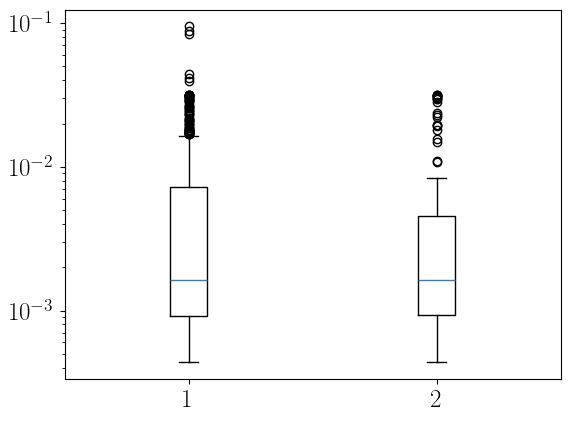

In [6]:
plt.boxplot([train_error,test_error])
plt.gca().set_yscale('log')

In [6]:
pod_pred_train = pod.expand(backstep.rbf(params_train))
pod_pred_test = pod.expand(backstep.rbf(params_test))

# pod_train_error = err(snapshots_train, pod_pred_train)
# pod_test_error = err(snapshots_test, pod_pred_test)
pod_train_error = (torch.linalg.norm(pod_pred_train-snapshots_train,dim=-1)/torch.linalg.norm(snapshots_train,dim=-1)).tensor.cpu().detach().numpy()
pod_test_error = (torch.linalg.norm(pod_pred_test-snapshots_test,dim=-1)/torch.linalg.norm(snapshots_test,dim=-1)).tensor.cpu().detach().numpy()

# np.save('./full_data/backstep/pod_train_error',pod_train_error)
# np.save('./full_data/backstep/pod_test_error',pod_test_error)


print('train',pod_train_error.mean(),pod_train_error.std())
print('test',pod_test_error.mean(),pod_test_error.std())


train 0.014610639 0.022936653
test 0.014625435 0.021799393


In [ ]:
#print(torch.min(rom.problem.conditions["correction"].output_points))
#print(torch.max(rom.problem.conditions["correction"].output_points))
#print(rom.modes@corr_net.C())

mus = torch.tensor([0.2,0.4,0.6,0.8]).cuda()[:,None]

for i in range(4):
    cs = corr_net.C(mus).tensor
    c = cs[i,...]
    print(rom.modes@c)
    list_labels = [f'{i}' for i in range(0,reddim*(reddim+1)//2)]
    list_fields = [c[:,i].detach().cpu().numpy().reshape(-1) for i in range(0,reddim*(reddim+1)//2)]
    vmin = min([field.min() for field in list_fields])
    vmax = max([field.max() for field in list_fields])
    plot(data.triang,list_fields,list_labels,
             filename=f'img/c_entries_net_mu_backstep{mus[i].item():.2f}.png',
             vmin = vmin,
             vmax = vmax)

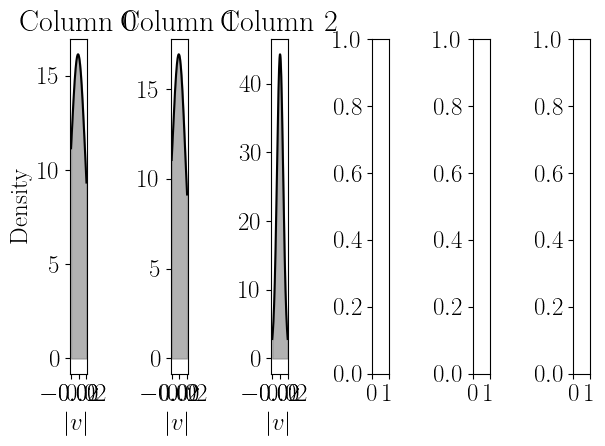

labels(['mu'])
LabelTensor([[[0.3936]]])
(0.00726049579679966, 0.001936237677000463) (0.006661722436547279, 0.00195446889847517)


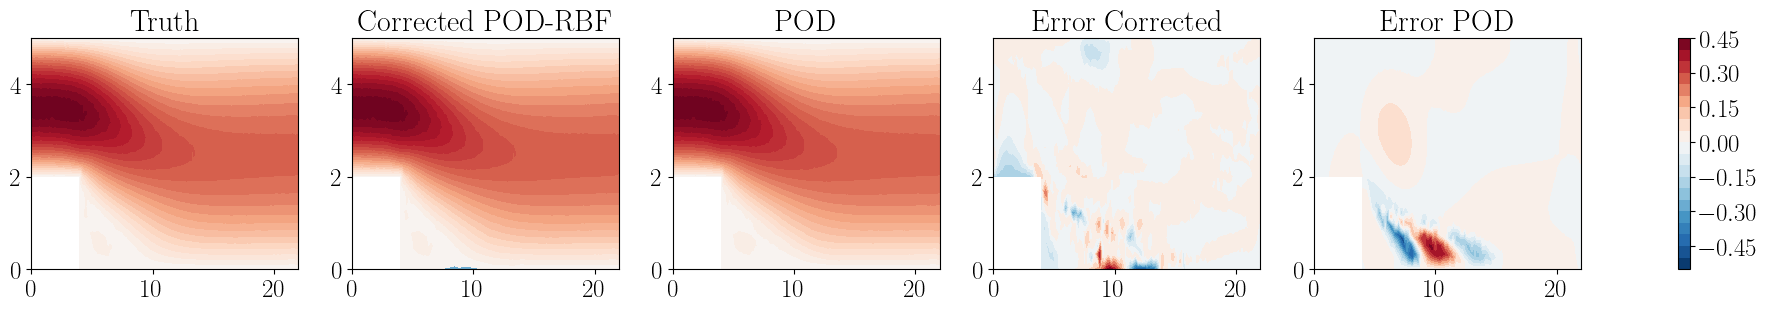

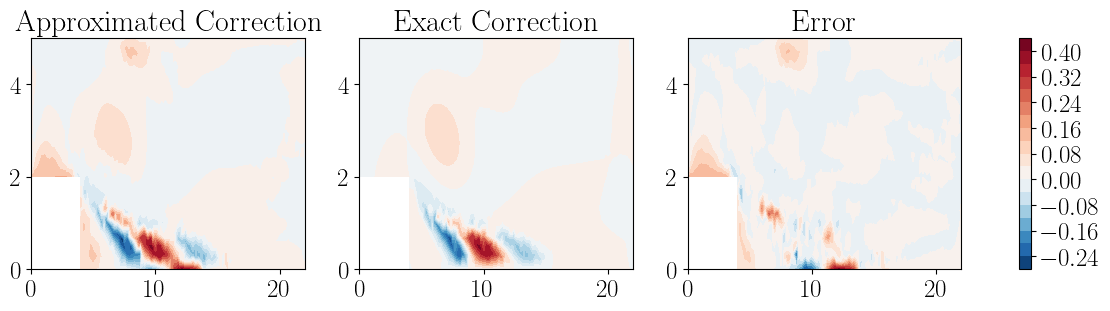

In [180]:
fig,axs = plt.subplots(1,6)
axs = axs.ravel()
x = np.linspace(-0.02,0.02,200)
for i,field in enumerate(list_fields):
        ax = axs[i]
        # ax = fig.add_subplot(1,6,1+i)
        # pos = poss[i]
        # ax = fig.add_axes([pos.x0, pos.y0, pos.width , 0.3])
        dens = gaussian_kde(field)
        ax.plot(x,dens(x),'k')
        ax.fill_between(x,np.zeros_like(x),dens(x),color='grey',alpha=0.6)
        ax.set_title(f'Column {i}')
        ax.set_xlabel('$|v|$')
axs[0].set_ylabel('Density')
fig.tight_layout()
plt.show()


# Plot the modes with the same function
#modes = rom.neural_net["correction_network"].modes
#modes = modes.detach().numpy()
#list_fields = [modes[:, i] for i in range(modes.shape[1])]
#list_labels = [f'Mode {i}' for i in range(modes.shape[1])]
##plot(data.triang,list_fields, list_labels, filename='img/transformed_modes_10kepochs')
#for i in range(reddim):
#    list_fields = [modes[:, i].reshape(-1)]
#    #list_fields = [modes.detach().numpy()[:, i].reshape(-1)
#    #        for i in range(reddim)]
#    list_labels = [f'Corrected mode {i+1}']# for i in range(reddim)]
#    plot(data.triang,list_fields, list_labels,filename=f'img/modes{i+1}_deep_sparse')
##exit()


# Evaluate the ROM on train and test
predicted_snaps_train = rom(params_train)
predicted_snaps_test = rom(params_test)
print(params_test[10])
#np.save('deep_prediction_10',predicted_snaps_test[10].detach().numpy())
train_error = err(snapshots_train, predicted_snaps_train)
test_error = err(snapshots_test, predicted_snaps_test)
#print('Train error = ', err(snapshots_train, predicted_snaps_train))
#print('Test error = ', err(snapshots_test, predicted_snaps_test))
print(train_error,test_error)
#exit()

# Plot the test results (POD-RBF and POD-RBF corrected)
ind_test = 2
snap = snapshots_test[ind_test].detach().numpy().reshape(-1)
pred_snap = predicted_snaps_test[ind_test].detach().numpy().reshape(-1)
# POD-RBF (fit and predict)
pod_rbf = PODRBF(pod_rank=reddim, rbf_kernel='thin_plate_spline')
pod_rbf.fit(params_train, snapshots_train)
pred_pod_rbf = pod_rbf(params_test).detach().numpy()[ind_test].reshape(-1)
list_fields = [snap, pred_snap, pred_pod_rbf,
        snap - pred_snap, snap-pred_pod_rbf]
list_labels = ['Truth', 'Corrected POD-RBF', 'POD',
        'Error Corrected', 'Error POD']
plot(data.triang,list_fields, list_labels, filename='img/quadnet_compare')

# Plot test correction (approximated and exact)
coeff_orig = rom.neural_net["interpolation_network"](params_test)
corr_scaler = rom.neural_net["correction_network"].scaler
# scale the predicted correction back to original scale
corr = corr_net(params_test,coeff_orig)
#if corr_scaler is not None:
#    corr = corr_scaler.inverse_transform(corr)
corr = corr.detach().numpy()[ind_test, :].reshape(-1)
exact_corr = compute_exact_correction(pod, snapshots_test)
if corr_scaler is not None:
    exact_corr = corr_scaler.transform(exact_corr)
exact_corr = exact_corr[ind_test].detach().numpy().reshape(-1)
list_fields = [corr, exact_corr, corr - exact_corr]
list_labels = ['Approximated Correction', 'Exact Correction', 'Error']
plot(data.triang,list_fields, list_labels, filename='img/quadnet_correction')

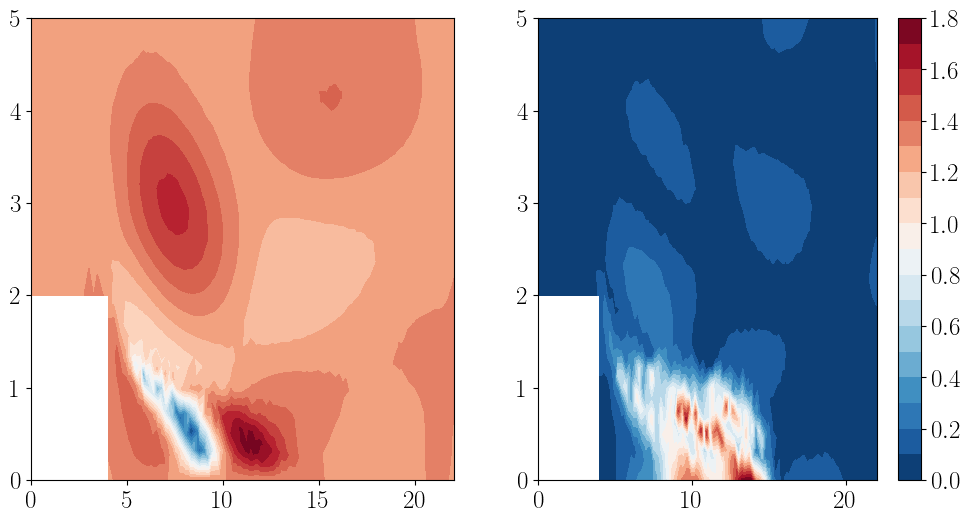

In [95]:
def compute_gradients_matplotlib(triangulation, values):
    """
    Compute gradients of a scalar field at nodes for a matplotlib.tri.Triangulation.
    
    Parameters:
        triangulation: matplotlib.tri.Triangulation
            A Triangulation object containing node and triangle information.
        values: ndarray of shape (N,)
            Scalar values defined at the nodes.
    
    Returns:
        gradients: ndarray of shape (N, 2)
            Gradients of the scalar field at the nodes.
    """
    # Extract points and triangles
    points = triangulation.x, triangulation.y
    triangles = triangulation.triangles
    nodes = np.column_stack(points)

    gradients = np.zeros((nodes.shape[0], 2))
    weight_sums = np.zeros(nodes.shape[0])

    for triangle in triangles:
        p1, p2, p3 = nodes[triangle]
        v1, v2, v3 = values[triangle]

        # Triangle area
        matrix = np.array([
            [p2[0] - p1[0], p3[0] - p1[0]],
            [p2[1] - p1[1], p3[1] - p1[1]]
        ])
        area = 0.5 * np.abs(np.linalg.det(matrix))

        # Gradients in the triangle
        grad = np.linalg.inv(matrix.T) @ np.array([v2 - v1, v3 - v1])

        # Add contribution to nodes
        for i, node_index in enumerate(triangle):
            gradients[node_index] += grad * area
            weight_sums[node_index] += area

    # Normalize by weights
    gradients /= weight_sums[:, np.newaxis]
    return gradients

# Example usage
# Generate a random triangulation using matplotlib

triangulation = data.triang

corrections = backstep.exact_correction.detach().numpy()
avg = np.zeros_like(corrections[0])
for i in range(corrections.shape[0]):
    values = corrections[i]

    # Compute gradients
    node_gradients = compute_gradients_matplotlib(triangulation, values)
    avg += np.linalg.norm(node_gradients,axis=-1)
avg /= (i+1)

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].tricontourf(triangulation,values,levels=20)
t2 = ax[1].tricontourf(triangulation,avg,levels=20)
plt.colorbar(t2)

In [147]:
type(corrections)

numpy.ndarray

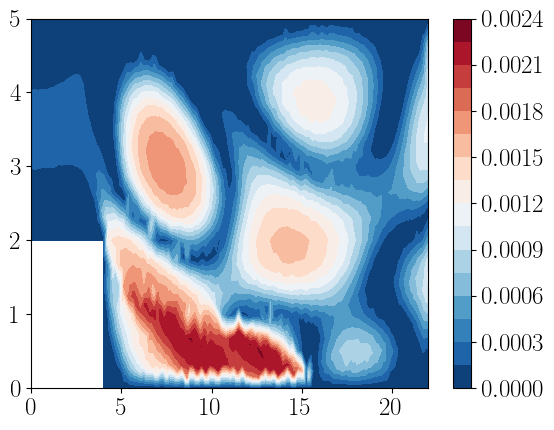

In [182]:
#p = np.exp(-np.mean(avg)/(avg+1e-6))
p = np.exp(-np.mean(np.abs(corrections))/(np.mean(np.abs(corrections),axis=0)+1e-6)) #+ 1/1639
p /= np.sum(p)
tp = plt.tricontourf(triangulation,p,levels=20)
plt.colorbar(tp)
#plt.gcf().savefig("quadnet/backstep_20_pts_p/probability_density")

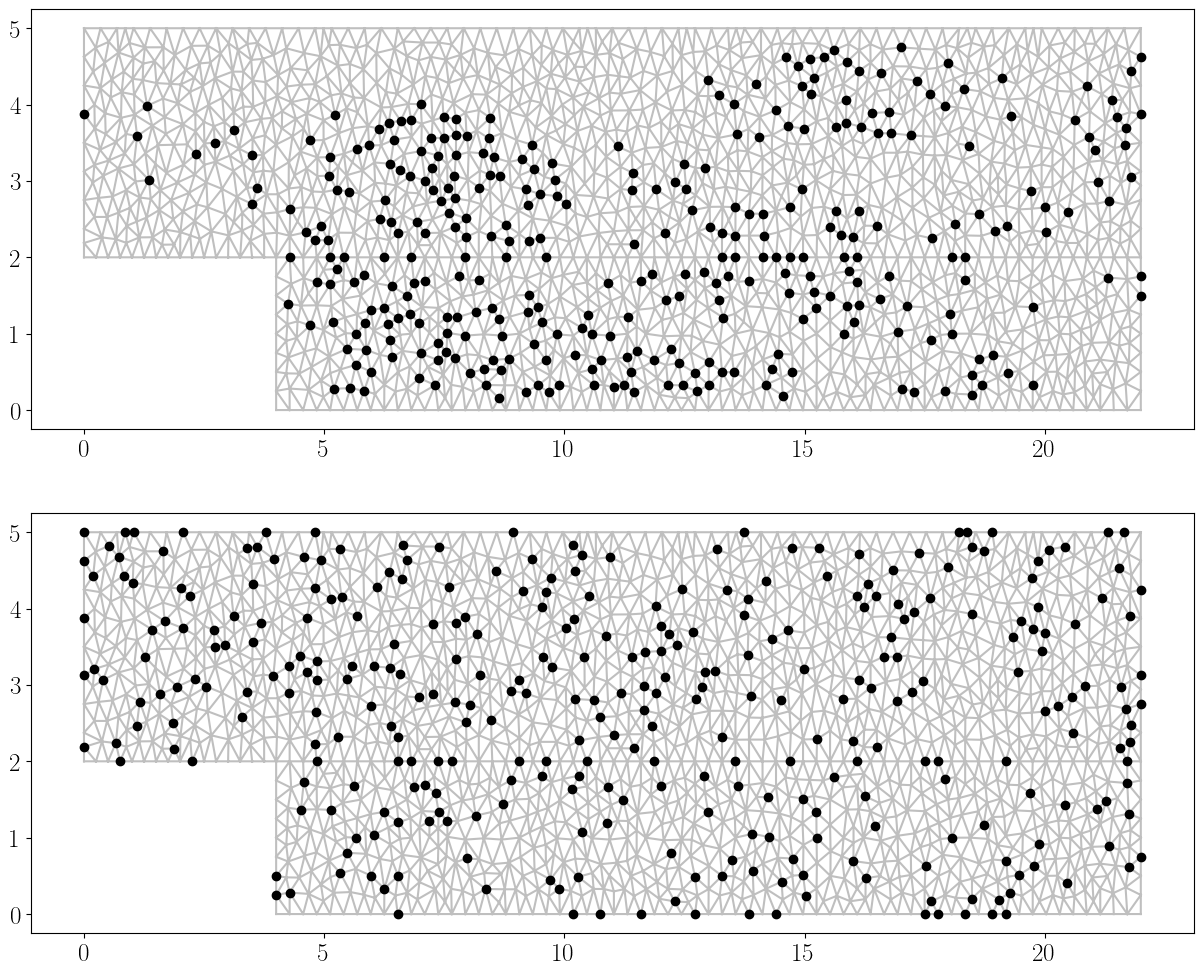

In [166]:
ind = np.random.choice(range(1639), int(0.2*1639), replace= False, p = p)
ind_unif = np.random.choice(range(1639), int(0.2*1639), replace= False)
fig,ax = plt.subplots(2,1,figsize=(15,12))
ax[0].triplot(triangulation,c='grey',alpha=0.5,zorder=-1)
ax[0].scatter(triangulation.x[ind],triangulation.y[ind],color='k')
ax[1].triplot(triangulation,c='grey',alpha=0.5,zorder=-1)
ax[1].scatter(triangulation.x[ind_unif],triangulation.y[ind_unif],color='k')